# ADABOOST TRAINING ALGORITHM


In [6]:
# All The Necessary Imports
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
from PIL import Image



The dataset structure may be in the form archive->Train->Train and then the label folders. This weird structure needs to be fixed manually before preprocessing the data. Just copy&paste such that it is in the form archive->Train->Label folders. We also process data to a new 'resized' folder that contains the images in the .npy format so that the data can later be reused much faster, even if the kernel restarts.


In [19]:
# Here we process data and save it as .npy for later use
# Set paths
dataset_dir = "archive"  # Replace with your actual dataset path
output_dir = "resized"    # Path to save processed images

# Parameters
image_size = (128, 128)  # Resize images to 128x128 pixels

# Create the output directory if it doesn't exist
Path(output_dir).mkdir(parents=True, exist_ok=True)

# Iterate over the main directories (e.g., Test, Train, Validation)
for main_folder in os.listdir(dataset_dir):
    main_folder_path = os.path.join(dataset_dir, main_folder)
    if not os.path.isdir(main_folder_path):
        continue
    
    # Iterate over subdirectories (labels: Healthy, Powdery, Rust)
    for label in os.listdir(main_folder_path):
        label_path = os.path.join(main_folder_path, label)
        if not os.path.isdir(label_path):
            continue
        
        # Create corresponding output subdirectory
        output_label_dir = os.path.join(output_dir, main_folder, label)
        Path(output_label_dir).mkdir(parents=True, exist_ok=True)
        
        for image_file in os.listdir(label_path):
            try:
                # Load the image
                image_path = os.path.join(label_path, image_file)
                img = Image.open(image_path).convert('RGB')  # Ensure 3 channels (RGB)
                
                # Resize the image
                img_resized = img.resize(image_size)
                
                # Normalize the pixel values
                img_array = np.array(img_resized) / 255.0  # Normalize to range [0, 1]
                
                # Save the processed image
                output_image_path = os.path.join(output_label_dir, image_file.replace('.jpg', '.npy'))
                np.save(output_image_path, img_array)  # Save as .npy file
            except Exception as e:
                print(f"Error processing {image_file} in {label_path}: {e}")

print("Image resizing and normalization complete!")

Image resizing and normalization complete!


In [26]:
# Function to Load Preprocessed .npy Image Data
def load_npy_dataset(dataset_dir):
    """
    Loads preprocessed .npy image data and labels from the dataset directory.

    Args:
        dataset_dir (str): Path to the dataset directory.

    Returns:
        X (numpy.ndarray): Array of preprocessed image data.
        y (numpy.ndarray): Array of corresponding labels.
        label_map (dict): Mapping of folder names (labels) to numerical indices.
    """
    X, y = {}, {}
    label_map = {}  # Map folder names to numerical indices
    label_counter = 0

    # Iterate over main folders (e.g., Test, Train, Validation)
    for main_folder in os.listdir(dataset_dir):
        main_folder_path = os.path.join(dataset_dir, main_folder)
        if not os.path.isdir(main_folder_path):
            continue
        X[main_folder] = []
        y[main_folder] = []
        # Iterate over subfolders (e.g., Healthy, Powdery, Rust)
        for label in os.listdir(main_folder_path):
            label_path = os.path.join(main_folder_path, label)
            if not os.path.isdir(label_path):
                continue

            # Map folder names to numerical labels
            if label not in label_map:
                label_map[label] = label_counter
                label_counter += 1

            # Load .npy files from the subfolder
            for npy_file in os.listdir(label_path):
                if npy_file.endswith('.npy'):
                    try:
                        npy_path = os.path.join(label_path, npy_file)
                        img_array = np.load(npy_path)  # Load preprocessed .npy file
                        X[main_folder].append(img_array)
                        y[main_folder].append(label_map[label])
                    except Exception as e:
                        print(f"Error loading {npy_file} in {label_path}: {e}")

    # Convert lists to numpy arrays
        X[main_folder] = np.array(X[main_folder], dtype=np.float32)
        y[main_folder] = np.array(y[main_folder], dtype=np.int32)
    return X, y, label_map

# Example Usage
dataset_dir = "resized"  # Replace with your dataset path
X, y, label_map = load_npy_dataset(dataset_dir)

print(f"Loaded {len(X)} labels:", list(X.keys()))
print ("X shape:", X['Train'].shape)
print ("y shape:", y['Train'].shape)

print("Label mapping:", label_map)
X_train = X['Train']
y_train = y['Train']
X_val = X['Validation']
y_val = y['Validation']
X_test = X['Test']
y_test = y['Test']

Loaded 3 labels: ['Train', 'Test', 'Validation']
X shape: (1322, 128, 128, 3)
y shape: (1322,)
Label mapping: {'Rust': 0, 'Healthy': 1, 'Powdery': 2}


In [27]:
# Function to Extract Features from Images

def extract_features(X, color_bins=(8, 8, 8), canny_threshold1=50, canny_threshold2=150):
    """
    Extracts features from an array of images X by computing:
      1) Color histogram (3D, e.g. 8x8x8 bins for R, G, B)
      2) Edge map (via Canny)

    Args:
        X (np.ndarray): Images array of shape (n_samples, height, width, 3).
                        Each image is in [0,1] float or [0,255] uint8 format.
        color_bins (tuple): Number of bins for each color channel in the histogram, e.g. (8, 8, 8).
        canny_threshold1, canny_threshold2 (int): Thresholds for Canny edge detection.

    Returns:
        X_features (np.ndarray): Feature matrix of shape (n_samples, n_features),
                                 where n_features = (product of color_bins) + (height * width for edges).
    """
    n_samples = X.shape[0]
    X_features = []

    for i in range(n_samples):
        # Extract the i-th image
        img = X[i]  # shape: (height, width, 3)

        # Ensure the image is in uint8 format with range [0,255]
        if img.dtype != np.uint8:
            img_uint8 = (img * 255).astype(np.uint8)
        else:
            img_uint8 = img

        # 1) COLOR HISTOGRAM
        #   - OpenCV uses BGR by default, but let's assume X is RGB.
        #   - So no color conversion needed if you are certain it's RGB. Otherwise:
        #     img_uint8_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)  # if needed
        #   - We'll just compute hist on the given RGB channels.

        hist = cv2.calcHist(
            [img_uint8], 
            channels=[0, 1, 2],  # R=0, G=1, B=2 if X is in RGB
            mask=None,
            histSize=color_bins,  # e.g. (8, 8, 8)
            ranges=[0, 256, 0, 256, 0, 256]
        )
        cv2.normalize(hist, hist)  # In-place normalization (default is L2 norm)

        # Flatten the histogram
        color_hist_features = hist.flatten()

        # 2) EDGE DETECTION
        # Convert to grayscale for Canny
        gray_img = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)

        # Canny edge detection
        edges = cv2.Canny(gray_img, threshold1=canny_threshold1, threshold2=canny_threshold2)
        # edges: 0 for no edge, 255 for edge

        # Flatten edges
        edge_features = edges.flatten().astype(np.float32) / 255.0  # scale to [0,1]

        # COMBINE features
        combined_features = np.concatenate((color_hist_features, edge_features))
        X_features.append(combined_features)

    # Convert to np.array
    X_features = np.array(X_features, dtype=np.float32)
    return X_features

# Extract features for each split
X_train_feat = extract_features(X_train, color_bins=(8,8,8), canny_threshold1=50, canny_threshold2=150)
X_val_feat   = extract_features(X_val,   color_bins=(8,8,8), canny_threshold1=50, canny_threshold2=150)
X_test_feat  = extract_features(X_test,  color_bins=(8,8,8), canny_threshold1=50, canny_threshold2=150)

print("Train feature shape:", X_train_feat.shape)
print("Val   feature shape:", X_val_feat.shape)
print("Test  feature shape:", X_test_feat.shape)


Train feature shape: (1322, 16896)
Val   feature shape: (60, 16896)
Test  feature shape: (150, 16896)


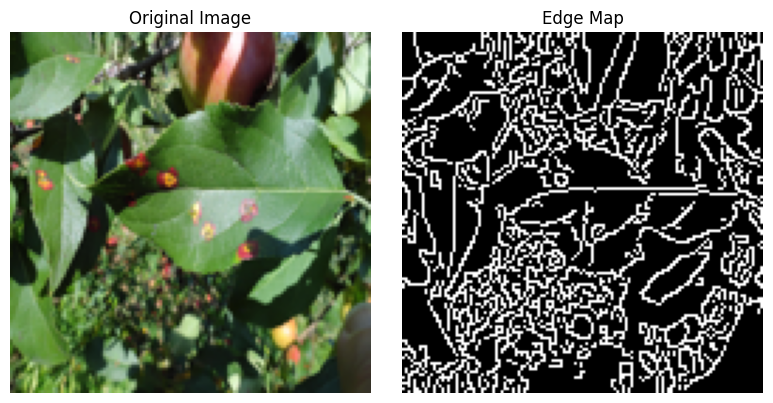

In [28]:
# Function to Visualize Edge Map for a Single Image to Check the Edge Detection

def show_edge_map(X, index=0, canny_threshold1=50, canny_threshold2=150):
    """
    Visualizes the edge map for a single image in X.

    Args:
        X (np.ndarray): Original images array of shape (n_samples, height, width, 3).
                        Pixels could be in [0,1] float or [0,255] uint8.
        index (int)   : Index of the image to visualize.
        canny_threshold1, canny_threshold2 (int): Canny edge detection thresholds.
    """
    # 1) Extract the i-th image
    img = X[index]

    # 2) Convert to uint8 if needed (0..255 range)
    if img.dtype != np.uint8:
        img_uint8 = (img * 255).astype(np.uint8)
    else:
        img_uint8 = img

    # 3) Convert to grayscale
    gray_img = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)

    # 4) Perform Canny edge detection
    edges = cv2.Canny(gray_img, threshold1=canny_threshold1, threshold2=canny_threshold2)

    # 5) Display side by side
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Original image
    axs[0].imshow(img_uint8)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    # Edge map
    axs[1].imshow(edges, cmap="gray")
    axs[1].set_title("Edge Map")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()


show_edge_map(X_train, index=5)


In [29]:
def train_and_evaluate_ada(params, X_train, y_train, X_val, y_val):
    """
    Builds an AdaBoost model using the specified 'params' dictionary,
    trains on (X_train, y_train), and returns validation accuracy.
    """
    # Copy the base params so we don't mutate them
    used_params = copy.deepcopy(params)
    
    # Extract max_depth (for DecisionTree), if provided
    max_depth = used_params.pop('max_depth', 1)
    
    # Prepare the base estimator
    base_estimator = DecisionTreeClassifier(
        max_depth=max_depth, random_state=42
    )
    
    # Build AdaBoost model
    adaboost = AdaBoostClassifier(
        estimator=base_estimator,
        **used_params,        # n_estimators, learning_rate, algorithm, etc.
        random_state=42       # for reproducibility
    )
    
    # Train
    adaboost.fit(X_train, y_train)
    
    # Evaluate
    y_val_pred = adaboost.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    training_accuracy = accuracy_score(y_train, adaboost.predict(X_train))
    return accuracy,training_accuracy, adaboost


In [31]:
# HyperParameter Tuning for AdaBoost
base_params = {
    'n_estimators': 100,
    'learning_rate': 1.0,
    'max_depth': 1         # we'll apply this to base_estimator=DecisionTreeClassifier
}
param_sweeps = [
    ('n_estimators', [50, 100, 200, 300, 500]),
    ('learning_rate', [0.001, 0.01, 0.1, 0.5, 1.0]),
    ('max_depth', [1, 2, 3, 5])
]

def sweep_params_one_by_one(
    base_params, 
    param_sweeps, 
    X_train, y_train, 
    X_val, y_val
):
    """
    For each (param_name, values_list) in param_sweeps,
    iterate over values_list while holding other parameters at base_params,
    collect validation accuracy, and plot results.
    
    Also returns a dict of { param_name: (best_value, best_accuracy) }.
    """
    
    best_results = {}
    # Save the best model as well
    best_model = None
    for (param_name, values_list) in param_sweeps:
        accuracies = []
        training_accuracies = []
        for val in values_list:
            # 1. Copy base_params
            current_params = base_params.copy()
            
            # 2. Insert the value for the parameter we are sweeping
            current_params[param_name] = val
            
            # 3. Train and evaluate
            acc,training_acc, model = train_and_evaluate_ada(current_params, X_train, y_train, X_val, y_val)
            # check if the accuracy is the best
            max_acc = max(accuracies) if len(accuracies) > 0 else 0
            if acc > max_acc:
                best_model = model

            accuracies.append(acc)
            training_accuracies.append(training_acc)
            print(f"Param: {param_name} = {val}, Val Accuracy: {acc:.4f}")
        
        # Plot param_name vs. accuracy
        plt.figure(figsize=(6,4))
        plt.plot(values_list, accuracies, marker='o', label = 'Validation Accuracy',color='blue')    
        plt.plot(values_list, training_accuracies, marker='o',label = 'Training Accuracy',color='red',linestyle='dashed')
        plt.title(f"Sweep for '{param_name}'")
        plt.xlabel(param_name)
        plt.legend()
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.show()
        
        # Find best value
        best_idx = max(range(len(accuracies)), key=lambda i: accuracies[i])
        best_val = values_list[best_idx]
        best_acc = accuracies[best_idx]
        
        best_results[param_name] = (best_val, best_acc, best_model)
    
    
    return best_results


Param: n_estimators = 50, Val Accuracy: 0.8000
Param: n_estimators = 100, Val Accuracy: 0.8333
Param: n_estimators = 200, Val Accuracy: 0.9000
Param: n_estimators = 300, Val Accuracy: 0.8500
Param: n_estimators = 500, Val Accuracy: 0.9000


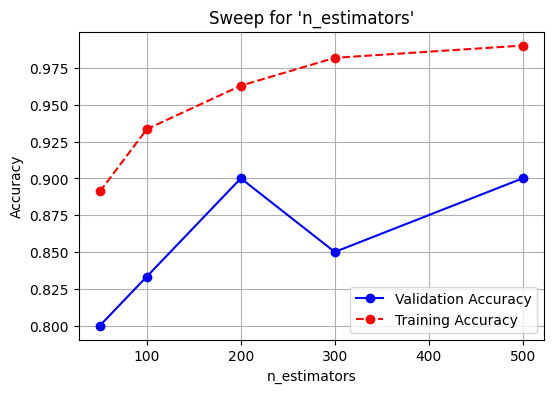

Param: learning_rate = 0.001, Val Accuracy: 0.5500
Param: learning_rate = 0.01, Val Accuracy: 0.6333
Param: learning_rate = 0.1, Val Accuracy: 0.8167
Param: learning_rate = 0.5, Val Accuracy: 0.8333
Param: learning_rate = 1.0, Val Accuracy: 0.8333


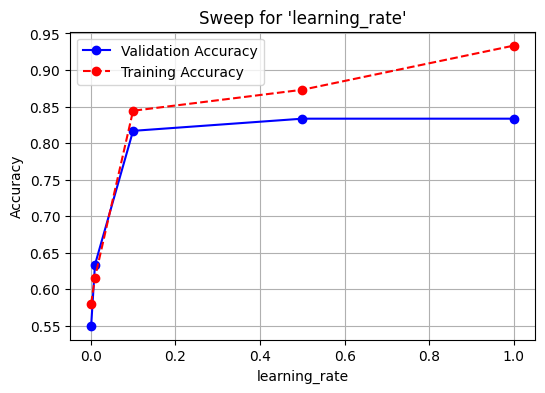

Param: max_depth = 1, Val Accuracy: 0.8333
Param: max_depth = 2, Val Accuracy: 0.9667
Param: max_depth = 3, Val Accuracy: 0.9333
Param: max_depth = 5, Val Accuracy: 0.9500


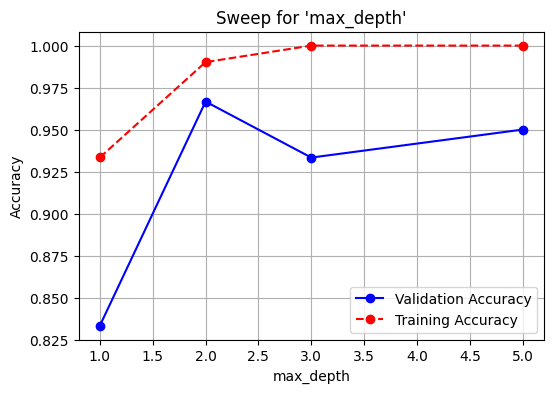

Individual best results from each sweep: {'n_estimators': (200, 0.9, AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=42),
                   n_estimators=200, random_state=42)), 'learning_rate': (0.5, 0.8333333333333334, AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1,
                                                    random_state=42),
                   learning_rate=0.5, n_estimators=100, random_state=42)), 'max_depth': (2, 0.9666666666666667, AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2,
                                                    random_state=42),
                   n_estimators=100, random_state=42))}


In [32]:

best_results = sweep_params_one_by_one(
    base_params,
    param_sweeps,
    X_train_feat, y_train,
    X_val_feat, y_val
)

print("Individual best results from each sweep:", best_results)


Test Accuracy: 0.8600


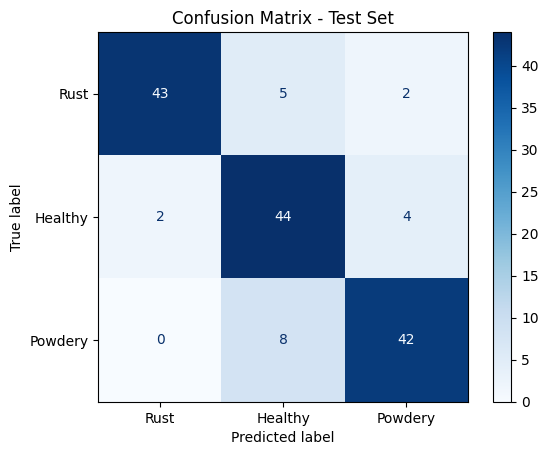

In [33]:
# Find the best model from the best results
best_model = None
best_acc_f = 0
for param_name, (best_val, best_acc, model) in best_results.items():
    if best_acc > best_acc_f:
        best_model = model
        best_acc_f = best_acc
# Test and plot the confusion matrix
y_test_pred = best_model.predict(X_test_feat)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")


# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map.keys())
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.show()


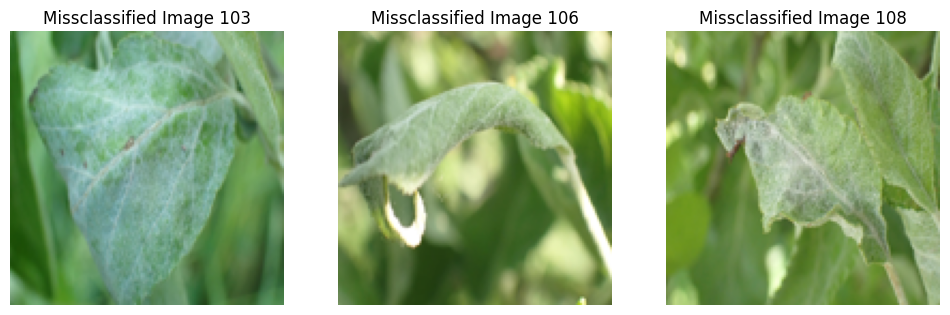

<Figure size 1200x400 with 0 Axes>

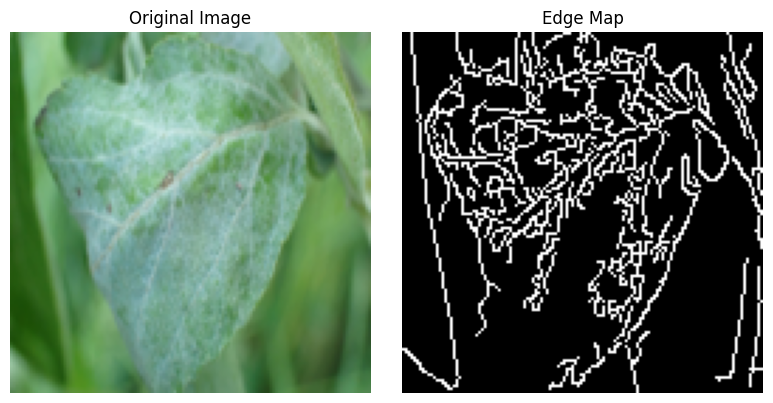

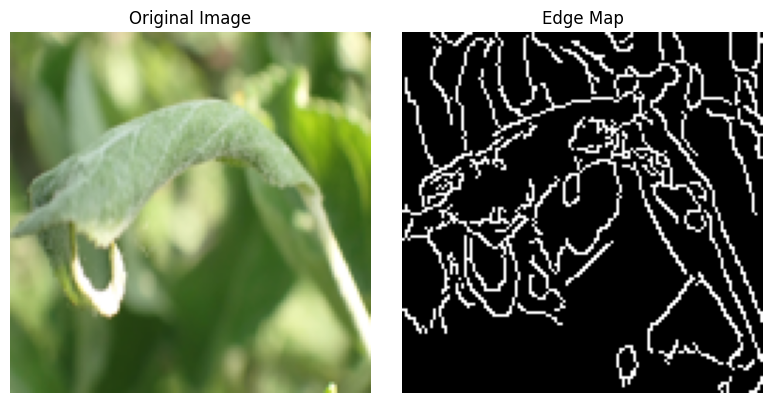

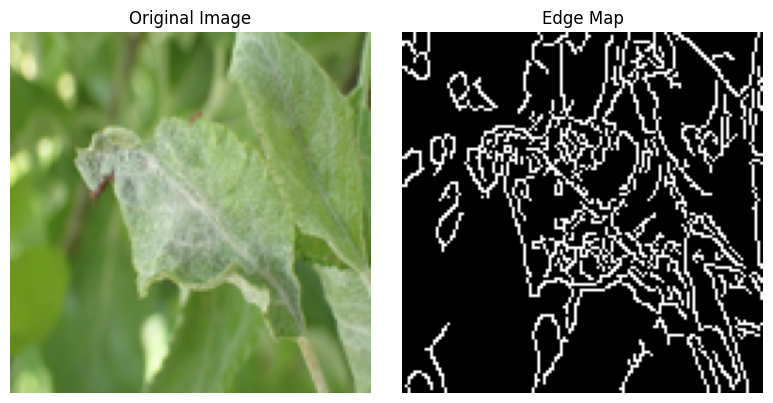

In [34]:
# Get missclassified label 2 as label 1
missclassified_indices = np.where((y_test == 2) & (y_test_pred == 1))[0]
# Plot the first 3 missclassified images and their edge maps
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, idx in enumerate(missclassified_indices[:3]):
    img = X_test[idx]
    axs[i].imshow(img)
    axs[i].set_title(f"Missclassified Image {idx}")
    axs[i].axis("off")
# Plot edge maps
plt.figure(figsize=(12, 4))
for i, idx in enumerate(missclassified_indices[:3]):
    show_edge_map(X_test, index=idx)
# Show the edge maps
